# Import Library

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import warnings
warnings.filterwarnings('ignore')

# Get & Show Data

In [2]:
!gdown 1r7HBlYWqh_u8T6CBtONLxqWhwfPMf7xI

Downloading...
From (original): https://drive.google.com/uc?id=1r7HBlYWqh_u8T6CBtONLxqWhwfPMf7xI
From (redirected): https://drive.google.com/uc?id=1r7HBlYWqh_u8T6CBtONLxqWhwfPMf7xI&confirm=t&uuid=720f27cf-2dd3-4345-bf57-99194b76e1cb
To: /content/Drowsy_Dataset.zip
100% 68.9M/68.9M [00:01<00:00, 42.4MB/s]


In [3]:
!unzip /content/Drowsy_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Drowsy_Dataset/train/alert/image_e2ce6df7-4688-4911-a1eb-adaa709e7fbe.jpg  
  inflating: Drowsy_Dataset/train/alert/image_e2d0cad4-3bbc-4730-bf2d-24ac026346f2.jpg  
  inflating: Drowsy_Dataset/train/alert/image_e2f365b2-b867-4a15-86b5-bb6f6a098a5c.jpg  
  inflating: Drowsy_Dataset/train/alert/image_e3093f23-c9c4-4d6b-8627-f47e6c9ca35a.jpg  
  inflating: Drowsy_Dataset/train/alert/image_e30a1f49-c70f-4a64-b195-7a85fc834495.jpg  
  inflating: Drowsy_Dataset/train/alert/image_e31a568c-120e-4f6b-a115-ca2a53a07d73.jpg  
  inflating: Drowsy_Dataset/train/alert/image_e31cf4d2-dbf3-4a9d-a430-8f7e127fffd7.jpg  
  inflating: Drowsy_Dataset/train/alert/image_e3207e02-2c42-430d-8b9b-b5cdecd60e8a.jpg  
  inflating: Drowsy_Dataset/train/alert/image_e3271252-decd-42c2-adf6-04f3f07424f3.jpg  
  inflating: Drowsy_Dataset/train/alert/image_e3279ff8-623d-4fed-86fc-541808d36624.jpg  
  inflating: Drowsy_Dataset/train/alert/image_e32be258-d917

# Create Torch Dataset

In [4]:
class DrowsinessDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Root directory containing 'alert' and 'drowsy' subfolders.
            transform (callable, optional): Transform to apply on the images.
        """
        self.transform = transform
        self.img_files = []
        self.labels = []
        self.classes = []

        # Dynamically detect classes from the subfolders
        class_dirs = sorted(os.listdir(root_dir))
        self.classes = class_dirs  # E.g., ['alert', 'drowsy']

        # Load image file paths and labels
        for class_idx, class_name in enumerate(class_dirs):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)]
                self.img_files.extend(files)
                self.labels.extend([class_idx] * len(files))

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.
        Returns:
            tuple: (image, label) where image is a transformed image tensor and label is its class.
        """
        image_path = self.img_files[idx]
        image = Image.open(image_path).convert("RGB")  # Ensure images are in RGB format
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
img = cv2.imread("/content/Drowsy_Dataset/train/alert/image_0033e29c-89ff-4c8c-bc4e-40003fd2c712.jpg")
img.shape

(128, 128, 3)

# Create Model

In [6]:
class DrowsinessCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(DrowsinessCNN, self).__init__()

        # Using a more robust architecture
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [7]:
# Data transforms with augmentation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

print(type(train_transform))
# Data transforms for validation/testing
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = DrowsinessCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

<class 'torchvision.transforms.transforms.Compose'>
Using device: cuda


In [8]:
train_dir = "/content/Drowsy_Dataset/train"
valid_dir = "/content/Drowsy_Dataset/valid"
test_dir = "/content/Drowsy_Dataset/test"



train_dataset = DrowsinessDataset(root_dir=train_dir, transform=train_transform)
val_dataset = DrowsinessDataset(root_dir=valid_dir, transform=val_transform)
test_dataset = DrowsinessDataset(root_dir=test_dir, transform=val_transform)

print(f"Training samples: {train_dataset.__len__()}")
print(f"Validation samples: {val_dataset.__len__()}")
print(f"Test samples: {test_dataset.__len__()}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

Training samples: 8349
Validation samples: 840
Test samples: 2000


# Train Function and Loop

In [9]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch.

    Args:
        model: The PyTorch model to train.
        train_loader: DataLoader for the training dataset.
        criterion: Loss function.
        optimizer: Optimizer.
        device: Device to train on ('cuda' or 'cpu').

    Returns:
        epoch_loss (float): Average training loss.
        epoch_acc (float): Training accuracy.
    """
    model.train()  # Set model to training mode
    total_loss = 0.0
    all_labels = []  # Store all true labels
    all_preds = []   # Store all predictions

    # Progress bar for visualization
    pbar = tqdm(train_loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and update weights
        loss.backward()
        optimizer.step()

        # Update loss and store predictions
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())  # Convert predictions to numpy and store
        all_labels.extend(labels.cpu().numpy())  # Store actual labels (fixed here)

        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Compute average loss and accuracy
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc



def validate(model, val_loader, criterion, device):
    """
    Validate the model on the validation dataset.

    Args:
        model: The PyTorch model to evaluate.
        val_loader: DataLoader for the validation dataset.
        criterion: Loss function.
        device: Device to evaluate on ('cuda' or 'cpu').

    Returns:
        val_loss (float): Average validation loss.
        val_acc (float): Validation accuracy.
        metrics (tuple): Weighted precision, recall, and F1-score.
    """
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    all_labels = []  # Store all true labels
    all_preds = []   # Store all predictions

    with torch.no_grad():  # Disable gradient computation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Store predictions and true labels
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute average loss and accuracy
    val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)

    # Compute precision, recall, and F1-score
    metrics = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    return val_loss, val_acc, metrics

In [10]:
num_epochs = 10
best_val_loss = float('inf')
early_stopping_patience = 3
patience_counter = 0

for epoch in range(num_epochs):
  # Training phase
  train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

  # Validation phase
  val_loss, val_acc, (precision, recall, f1, _) = validate(model, val_loader, criterion, device)

  # Learning rate scheduling
  scheduler.step(val_loss)

  print(f'\nEpoch {epoch+1}/{num_epochs}:')
  print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
  print(f'Val Loss  : {val_loss:.4f}  , Val Acc: {val_acc:.4f}')
  print(f'Precision: {precision:.4f}  , Recall: {recall:.4f}, F1: {f1:.4f}')

  # Save best model
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    patience_counter = 0
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'val_loss' : val_loss,
        }, 'best_model.pth')
  else:
    patience_counter += 1
    if patience_counter == early_stopping_patience:
      print(f'\nEarly stopping triggered after {epoch+1} epochs')
      break

Training: 100%|██████████| 66/66 [00:22<00:00,  2.98it/s, loss=0.2338]



Epoch 1/10:
Train Loss: 0.2856, Train Acc: 0.8861
Val Loss  : 0.2535  , Val Acc: 0.8774
Precision: 0.8800  , Recall: 0.8774, F1: 0.8772


Training: 100%|██████████| 66/66 [00:17<00:00,  3.85it/s, loss=0.1261]



Epoch 2/10:
Train Loss: 0.1222, Train Acc: 0.9527
Val Loss  : 0.1862  , Val Acc: 0.9155
Precision: 0.9212  , Recall: 0.9155, F1: 0.9152


Training: 100%|██████████| 66/66 [00:17<00:00,  3.86it/s, loss=0.0365]



Epoch 3/10:
Train Loss: 0.0743, Train Acc: 0.9722
Val Loss  : 0.1235  , Val Acc: 0.9464
Precision: 0.9465  , Recall: 0.9464, F1: 0.9464


Training: 100%|██████████| 66/66 [00:17<00:00,  3.77it/s, loss=0.0413]



Epoch 4/10:
Train Loss: 0.0608, Train Acc: 0.9774
Val Loss  : 0.0926  , Val Acc: 0.9667
Precision: 0.9668  , Recall: 0.9667, F1: 0.9667


Training: 100%|██████████| 66/66 [00:17<00:00,  3.80it/s, loss=0.0657]



Epoch 5/10:
Train Loss: 0.0520, Train Acc: 0.9826
Val Loss  : 0.1153  , Val Acc: 0.9619
Precision: 0.9628  , Recall: 0.9619, F1: 0.9619


Training: 100%|██████████| 66/66 [00:17<00:00,  3.71it/s, loss=0.0062]



Epoch 6/10:
Train Loss: 0.0467, Train Acc: 0.9831
Val Loss  : 0.0932  , Val Acc: 0.9667
Precision: 0.9670  , Recall: 0.9667, F1: 0.9667


Training: 100%|██████████| 66/66 [00:17<00:00,  3.84it/s, loss=0.1007]



Epoch 7/10:
Train Loss: 0.0344, Train Acc: 0.9881
Val Loss  : 0.1388  , Val Acc: 0.9548
Precision: 0.9568  , Recall: 0.9548, F1: 0.9547

Early stopping triggered after 7 epochs


In [12]:
# Load best model
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

test_loss, test_acc, (test_precision, test_recall, test_f1, _) = validate(model, test_loader, criterion, device)
print('\nTest Results:')
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')


Test Results:
Test Loss: 0.0957
Test Precision: 0.9610
Test Recall: 0.9610
Test F1 Score: 0.9610


In [13]:
from google.colab import files

# Download the file to your local machine
files.download('/content/best_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

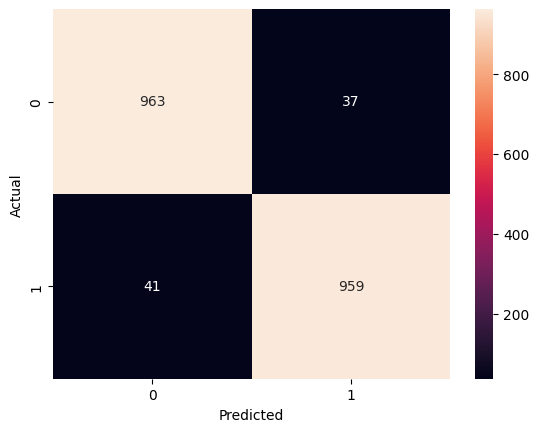

In [14]:
# test the model plot the predictions
model.eval()
test_preds = []
test_labels = []
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)
    test_preds.extend(preds.cpu().numpy())
    test_labels.extend(labels.cpu().numpy())

# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()